# Решающее дерево, Случайный лес, Ансамбль моделей (Bagging, RF)

#### Данный ноутбук представляет собой краткий конспект теории и выполнение практических заданий

Структура:  
1. Решающее дерево для задачи классификации  
        1.1 Классификация на искусственно сгенерированных данных
        1.2 Классификация для определения подлинности банкноты  
2. Решающее дерево для задачи регрессии  
        2.1 Регрессия на искусственно сгенерированных данных  
        2.2 Регрессия для предсказания потребления топлива  
3. Ансамбль моделей 
        3.1 Беггинг. Реализация бэггинга для деревьев решений. Метод случайных подпространств (RSS)  
        3.2 Случайный лес
             - Реализация Случайного леса для предсказания погоды
             - Реализация Случайного леса на примере датасета с информацией о сотрудниках компании
             - Классификация изображений с цифрами по численным признакам
        


In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from scipy import stats
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import (train_test_split, KFold, LeaveOneOut, cross_val_score, cross_validate, 
                                     StratifiedShuffleSplit, RandomizedSearchCV, GridSearchCV)
from sklearn.metrics import (mean_squared_error, log_loss, accuracy_score, balanced_accuracy_score,
                            precision_score, recall_score, f1_score, roc_auc_score, roc_curve, 
                            precision_recall_curve, average_precision_score, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.datasets import make_blobs, load_digits

# 1. Решающее дерево для задачи классификации 

**Формально дерево решений — это связный ациклический граф**  
Дерево строится жадно, начиная с одной вершины, разбивает её на две, после чего рекурсивно повторяет процедуру для новых дочерних вершин.

В дереве решений можно выделить **три типа вершин:**  
- Корневая вершина (root node) — откуда объекты из выборки начинают движение по дереву.  
- Внутренние вершины (intermediate nodes) - признак проверяется на некий логический критерий, по результатам которого объект движется глубже по дереву.    
- Листья (leafs) — самые глубокие вершины дерева, в которых содержится «ответ». Для решения задачи классификации возвращается наиболее популярный класс. Для регрессии, если функционал среднеквадратичная ошибка - возвращается усредненное значение. Ошибка оптимизируется при помощи **критериев информативности (Энтропия Шеннона, Джини)**.  

Формула энтропийного критерия информативности:   
(где Pk - вероятность встретить объект k-го класса в подвыборке)    
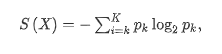

Формула критерия информативности Джини:   
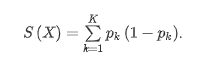

**IG (information Gain - прирост информации)** - изменение критерия информативности до и после разделения. Показывает насколько изменилась информативность при данном разделении.  
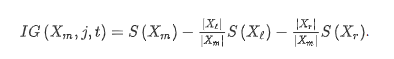


**Борьба с переобучением:**  
- Задать порог по мере неопределённости  
- Задать порог на глубину  
- Задать порог по размеру узла  
- Задать порог на размер потомков

## 1.1 Классификация на искусственно сгенерированных данных

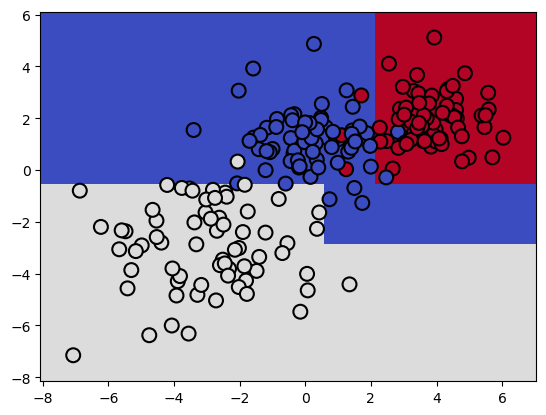

In [23]:
# Сгенерируем данные, обучим модель и отобразим на графике
RANDOM_SEED = 139

train_data, train_labels = make_blobs(n_samples = 200, centers = [(0, 1), (-3, -3), (4, 2)], 
                                      n_features = 2, random_state = RANDOM_SEED,
                                      cluster_std = (1.2, 1.5, 1,))

# Функция для визуализации
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Обучим решающее дерево
clf_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, 
                                  random_state = RANDOM_SEED)
clf_tree.fit(train_data, train_labels)

# Отрисуем разделяющую поверхность
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap = 'coolwarm')
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, s = 100, 
            cmap = 'coolwarm', edgecolors = 'black', linewidth = 1.5);

## 1.2 Классификация для определения подлинности банкноты 

Определим, является ли банкнота настоящей.  
В задании используется датасет bill_authentication.csv. Целевая переменная - Class.  
- Разделим выборку на обучающую и тестовую (test_size = 0.2, random_state = 17 для разбиения и построения дерева). 
- Обучим модель и посчитаем значение F1-scorе (параметры: максимальная глубина дерева = 3, максимальное число признаков, по которым ищется лучшее разбиение в дереве = 2).  

In [10]:
# Загрузим датасет и посмотрим на данные
bill_authentication = pd.read_csv('bill_authentication.csv')
display(bill_authentication.head(3))
display(bill_authentication.info())

,Variance,Skewness,Curtosis,Entropy,Class
0,3.6216,8.6661,-2.8073,-0.44699,0
1,4.5459,8.1674,-2.4586,-1.46210,0
2,3.8660,-2.6383,1.9242,0.10645,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Variance  1372 non-null   float64
 1   Skewness  1372 non-null   float64
 2   Curtosis  1372 non-null   float64
 3   Entropy   1372 non-null   float64
 4   Class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


None

In [26]:
# Разобьем выборку на тренировочную и тестовую, обучим классификатор и посчитаем значение F1-score
X, y = bill_authentication.iloc[:, :-1].values, bill_authentication.iloc[:, -1].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 17)

model = DecisionTreeClassifier(max_depth = 3, random_state = 17, max_features = 2).fit(X_train, y_train)
y_pred = model.predict(X_valid)

f1 = f1_score(y_valid, y_pred)
print(f'f1_score = {f1:.03}')

f1_score = 0.866


# 2. Решающее дерево для задачи регрессии

В случае регрессии (прогнозирования непрерывного числового признака) идея построения остается той же, но оптимизируется критерий  информативности, оценивающий разброс вещественных ответов:  
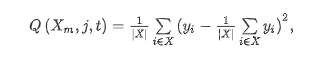

## 2.1 Регрессия на искусственно сгенерированных данных  

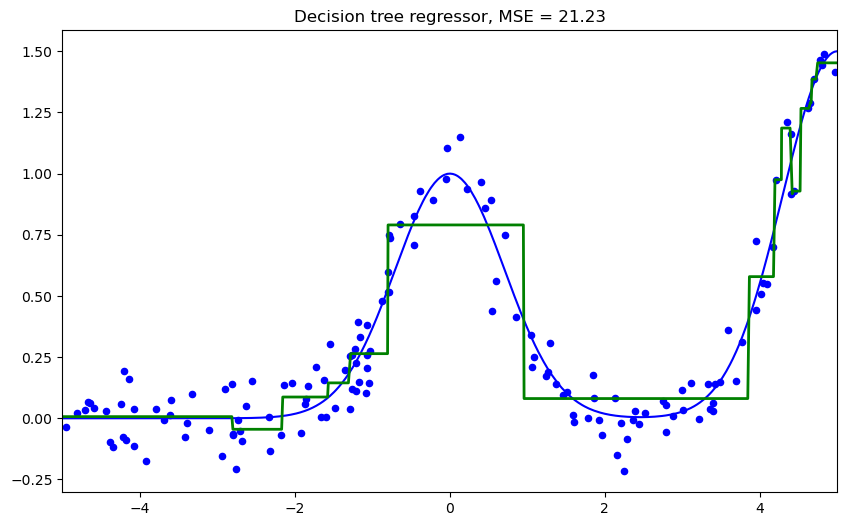

In [14]:
# Сгенерируем данные, обучим регрессор и отобразим на графике
RANDOM_SEED = 139

n_train = 150        
n_test = 1000       
noise = 0.1

def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 5) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 5) ** 2) + \
    np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

X_train, y_train = generate(n_samples = n_train, noise = noise)
X_test, y_test = generate(n_samples = n_test, noise = noise)

reg_tree = DecisionTreeRegressor(max_depth = 4, random_state = RANDOM_SEED)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

plt.figure(figsize = (10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c = "b", s = 20)
plt.plot(X_test, reg_tree_pred, "g", lw = 2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()

## 2.2 Регрессия для предсказания потребления топлива  

В задании используется датасет petrol_consumption.csv.   
- Разобьем выборку на обучающую и тестовую. 
- Обучим модель и вычислим RMSE (параметры: test_size = 0.3, random_state = 42 для разбиения и дерева). 

In [25]:
# Загрузим датасет и посмотрим на данные
petrol_cons = pd.read_csv('petrol_consumption.csv')
display(petrol_cons.head(3))
display(petrol_cons.info())

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,9.0,3571,1976,0.525,541
1,9.0,4092,1250,0.572,524
2,9.0,3865,1586,0.580,561


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Petrol_tax                    48 non-null     float64
 1   Average_income                48 non-null     int64  
 2   Paved_Highways                48 non-null     int64  
 3   Population_Driver_licence(%)  48 non-null     float64
 4   Petrol_Consumption            48 non-null     int64  
dtypes: float64(2), int64(3)
memory usage: 2.0 KB


None

In [26]:
# Разделим выборку, обучим модель и посчитаем значение RMSE
X, y = petrol_cons.iloc[:, :-1].values, petrol_cons.iloc[:, -1].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 42)

petrol_model = DecisionTreeRegressor(max_depth = 11, random_state = 42, max_features = 4).fit(X_train, y_train)
y_pred = petrol_model.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'RMSE: {rmse:.04}')

RMSE: 87.97


# 3. Ансамбль моделей (Bagging)

**Bagging (Bootstrap Aggregating) — частный случай ансамблирования, параллельный способ построения ансамбля, основанный на статистическом методе bootstrap.**      
Это метод построения композиции алгоритмов, в котором каждый алгоритм строится независимо от других на подвыборках обучающей выборки. Итоговый алгоритм принимает решение посредством голосования среди всех алгоритмов (простым или взвешенным голосованием). В группе модели снижают сдвиг и разброс ответов (bias and variance).   
В основе бэггинга лежит статистический метод **бутстрэп** (bootstrap - генерация выборок из исходного датасета путем случайного выбора элементов с повторениями.). Бутстрэп-выборки также часто используются для оценки различных статистических показателей (например, разброса или доверительного интервала). При бэггинге размер каждой бутстрэп-выборки должен совпадать с размером исходной выборки.

Коротко о способе построения ансамбля моделей Bagging:  
- Обучающая выборка сэмплируется k раз с помощью **bootstrap (выбор с возвращением)**.  
- На каждом сэмпле обучается **отдельная базовая модель**.
- Ответы моделей **усредняются (возможно, с весами - "ансамбль с голосованием")**.

### 3.1 Реализация бэггинга для деревьев решений
В задании используется датасет с информацией о качестве вина.    
- **Обучим логистическую регрессию, решающее дерево и бэггинг. Сравним результаты построенных моделей.**    
- Подготовим данные, обучим два классификатора (лог. регрессию и решающее дерево), посчитаем значение F1_score.  
- Затем обучим модель с использованием бэггинга (BaggingClassifier) для алгоритма, показавшего лучшее качество.  


In [39]:
# Загрузим датасет и посмотрим на данные
wine_qual = pd.read_csv('winequality-red.csv', sep = ';')
display(wine_qual.head(3))
display(wine_qual.info())
print(f'\nЗначения целевой переменной в исходном датасете: \n{wine_qual.quality.value_counts()}')

# Сконвертируем целевой стобец в бинарные значения
wine_qual.quality = wine_qual.quality.isin([6, 7, 8]).astype('int32')
print(f'\nЗначения целевой переменной после трансформации: \n{wine_qual.quality.value_counts()}')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


None


Значения целевой переменной в исходном датасете: 
5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

Значения целевой переменной после трансформации: 
1    855
0    744
Name: quality, dtype: int64


In [37]:
# Разделим выборку на test и valid
X, y = wine_qual[list(set(wine_qual.columns) - set(['quality']))].values, wine_qual.quality.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Обучим модель Логистической регрессии с параметрами по умолчанию и посчитаем f1_score
model_LR = LogisticRegression().fit(X_train, y_train)
y_pred_LR = model_LR.predict(X_valid)
f1_LR = f1_score(y_valid, y_pred_LR)
print(f'Логистическая регрессия. F1_score = {f1_LR:.05}')

# Обучим модель решающего дерева (С параметрами из условия задачи)
model_tree = DecisionTreeClassifier(random_state = 42, max_depth = 10).fit(X_train, y_train)
y_pred_tree = model_tree.predict(X_valid)
f1_tree = f1_score(y_valid, y_pred_tree)
print(f'Дерево решений. F1_score = {f1_tree:.05}')

# Обучим бэггинг над решающими деревьями (С параметрами из условий задачи) 
model_bg = BaggingClassifier(base_estimator = model_tree, random_state = 42, n_estimators = 1500).fit(X_train, y_train)
y_pred_bg = model_bg.predict(X_valid)
f1_bg = f1_score(y_valid, y_pred_bg)
print(f'Беггинг над деревьями решений. F1_score = {f1_bg:.05}')

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Логистическая регрессия. F1_score = 0.74621
Дерево решений. F1_score = 0.77117
Беггинг над деревьями решений. F1_score = 0.81664


Беггинг над решающими деревьями показал более высокое качество по сравнению с отдельными моделями. 

### Метод случайных подпространств (RSS - Random Subspaces)  
Базовые алгоритмы обучаются на различных подмножествах признакового описания, которые также выделяются случайным образом.  
RSS позволяет снизить скоррелированность между деревьями и избежать переобучения. Метод обеспечивает устойчивость алгоритма к набору доступных признаков. 

### 3.2 Случайный лес

**Случайный лес** — это ансамблевый алгоритм, это композиция глубоких деревьев, которые строятся независимо друг от друга, это бэггинг над решающими деревьями, при обучении которых для каждого разбиения признаки выбираются из некоторого случайного подмножества признаков.  

**Алгоритм построения Случайного леса**  

Для каждого дерева:  
- сгенерировать выборку при помощи статистического метода бутстрэп (сэмплирование с повоторениями);
- построить решающее дерево по выборке: по заданному критерию выбирается лучший признак, по которому происходит разбиение в дереве и так до исчерпания выборки → дерево строится, пока не сработает критерий остановки (порог на глубину, порог на размер потомков, порог на размер узла) → при каждом разбиении сначала выбирается несколько случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них.  

Случайный лес обучает набор деревьев (параметр n_esimators), каждое из которых учится на подмножестве признаков (RSS - Random Subspaces) и на подмножестве объектов (Bootstrap). Ответы агрегируются при помощи голосования. Как правило, в задачах классификации берут квадратный корень из числа признаков, а в задачах регрессии — треть числа признаков или log. 

###  Реализация Случайного леса для предсказания погоды
- В задании используется датасет c данными о погоде temps_extended.csv.  
- Проведем небольшую предобработку: удалим признаки, не относящиеся к предсказанию.  
- Разделим выборки, обучим модель и посчитаем значение метрик качества.  
- Подберем параметры при помощи класса **RandomizedSearchCV**.  

In [26]:
# Загрузим датасет и посмотрим на данные
weather = pd.read_csv('temps_extended.csv')
display(weather.head(3))
display(weather.info())

,year,month,day,weekday,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,actual,friend
0,2011,1,1,Sat,4.92,0.0,0,36,37,45.6,40,40
1,2011,1,2,Sun,5.37,0.0,0,37,40,45.7,39,50
2,2011,1,3,Mon,6.26,0.0,0,40,39,45.8,42,42


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     2191 non-null   int64  
 1   month    2191 non-null   int64  
 2   day      2191 non-null   int64  
 3   weekday  2191 non-null   object 
 4   ws_1     2191 non-null   float64
 5   prcp_1   2191 non-null   float64
 6   snwd_1   2191 non-null   int64  
 7   temp_2   2191 non-null   int64  
 8   temp_1   2191 non-null   int64  
 9   average  2191 non-null   float64
 10  actual   2191 non-null   int64  
 11  friend   2191 non-null   int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 205.5+ KB


None

In [31]:
# Удалим некоторые признаки и разделим выборку на обучающую и тестовую
y = weather['actual']
X = weather.drop(['actual','weekday','month','day','year'], axis = 1)
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Посмотрим параметры модели по умолчанию
rf = RandomForestRegressor(random_state = 42)
print('Параметры по умолчанию:\n')
pprint(rf.get_params())

Параметры по умолчанию:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Подберем значения для следующих параметров: n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf и bootstrap

In [34]:
# Подберем значения для параметров 
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Обучим модель с параметрами, предложенными RandomizedSearchCV  
rf = RandomForestRegressor(random_state = 42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, 
            verbose = 3, random_state = 42, n_jobs= -1)
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [38]:
# Посмотрим, какие гиперпараметры предлагаются как оптимальные
print('Подобранные гиперпараметры:')
display(rf_random.best_params_)

# Посмотрим на значение MSE с дефолтными и подобранными параметрами 
rf = RandomForestRegressor(random_state = 42).fit(X_train, Y_train)
Y_pred_default = rf.predict(X_val)
mse1 = mean_squared_error(Y_val, Y_pred_default)
print(f'Значение MSE при использовании параметров RandomForest по умолчанию: {mse1:.05}')

Y_pred_random = rf_random.predict(X_val)
mse2 = mean_squared_error(Y_val, Y_pred_random)
dif_mse = mse1 - mse2
print(f'Значение MSE с параметрами, подобранными с помощью RandomizedSearchCV: {mse2:.05}')
print(f'Улучшение значения MSE при использовании подобранных параметров: {dif_mse:.05}')

Подобранные гиперпараметры:


{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

Значение MSE при использовании параметров RandomForest по умолчанию: 24.571
Значение MSE с параметрами, подобранными с помощью RandomizedSearchCV: 23.101
Улучшение значения MSE при использовании подобранных параметров: 1.4701


### Реализация Случайного леса на примере датасета с информацией о сотрудниках компании  
В задании используется датасет HR-dataset.csv. Целевая переменная 'left'- обозначает, уволился ли сотрудник из компании.   
- Проведем небольшую предобработку.  
- Обучим несколько алгоритмов и оценим их качество на кросс-валидации на пяти фолдах при помощи Accuracy.

In [28]:
# Загрузим датасет и проведем базовую предобработку данных
hr_data = pd.read_csv('HR-dataset.csv')
display(hr_data.head(3))
display(hr_data.info())

,empid,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,dept,salary
0,1001,0.38,0.53,2,157,3,0,1,0,sales,low
1,1002,0.80,0.86,5,262,6,0,1,0,sales,medium
2,1003,0.11,0.88,7,272,4,0,1,0,sales,medium


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   empid                  14999 non-null  int64  
 1   satisfaction_level     14999 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   number_project         14999 non-null  int64  
 4   average_montly_hours   14999 non-null  int64  
 5   time_spend_company     14999 non-null  int64  
 6   Work_accident          14999 non-null  int64  
 7   left                   14999 non-null  int64  
 8   promotion_last_5years  14999 non-null  int64  
 9   dept                   14999 non-null  object 
 10  salary                 14999 non-null  object 
dtypes: float64(2), int64(7), object(2)
memory usage: 1.3+ MB


None

In [29]:
# Удалим признак, который отвечает за идентификатор пользователя, как нерепрезентативный  
# Разделим выборку на Х и y  
target = 'left'
features = hr_data.columns.drop(target)
features = features.drop('empid')
X, y = hr_data[features].copy(), hr_data[target]

# Заменим идентификатор отдела, к которому относился сотрудник, на количество людей в отделе  
X['dept'] = X['dept'].apply(X['dept'].value_counts().get)

# Заменим признак salary на ординальную категорию
salary_ord = {'low': 1, 'medium': 2, 'high': 3}
X['salary'] = X['salary'].apply(salary_ord.get)

# Масштабируем признаки
scaler = StandardScaler()
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)

# Будем оценивать качество модели на кросс-валидации на пяти фолдах при помощи Accuracy
def estimate_accuracy(clf, X, y, cv = 5):
    return cross_val_score(clf, X, y, cv = 5, scoring = 'accuracy').mean()

# Сравним точность одного дерева и композиции древьев
tree = DecisionTreeClassifier(max_depth = 30)
print('Decision tree: {:.06}'.format(estimate_accuracy(tree, X, y)))

bagging_trees = BaggingClassifier(tree)
print('Decision tree bagging: {:.06}'.format(estimate_accuracy(bagging_trees, X, y)))

Decision tree: 0.974931
Decision tree bagging: 0.988599


Ансамбль деревьев показал более высокий результат по сравнению с одним решающим деревом. Структура дерева сильно зависит от обучающей выборки. Если немного изменить обучающую выборку, то дерево значительно изменится. Ансамбль алгоритмов позволяет нивелировать вклад ошибок отдельных классификаторов. В группе алгоритмы дают более низкое смещение и разброс ответов (bias and variance).

In [30]:
# Увеличим различность построенных деревьев
random_tree = DecisionTreeClassifier(max_features = int(np.sqrt(len(features))), max_depth = 30)
print("Random tree: {:.06}".format(estimate_accuracy(random_tree, X, y)))

bagging_random_trees = BaggingClassifier(random_tree)
print("Random tree bagging: {:.06}".format(estimate_accuracy(bagging_random_trees, X, y)))

Random tree: 0.979066
Random tree bagging: 0.990266


**Именно так и работает случайный лес (Random Forest): он обучает набор деревьев (параметр n_esimators), каждое из которых обучается на подмножестве признаков (RSS - Random Subspaces) и подмножестве объектов (Bootstrap)**. Ответы агрегируются при помощи голосования.  

Как правило, в задачах классификации берут квадратный корень из числа признаков, а в задачах регрессии — треть числа признаков или log.

In [31]:
random_forest = RandomForestClassifier(n_estimators = 100,
                                       n_jobs = -1,
                                       max_features = int(np.sqrt(len(features))),
                                       max_depth = 30)
print(f'Random Forest: {estimate_accuracy(random_forest, X, y):.04}')

Random Forest: 0.9921


Ещё одним преимуществом Bagging является получение оценки работы классификатора при помощи **out-of-bag score (oobs)** без дополнительной кросс-валидации. **Параметр oob_score = True** (имеет смысл при достаточном количестве деревьев).

In [32]:
random_forest = RandomForestClassifier(n_estimators = 100,
                                       max_features = int(np.sqrt(len(features))),
                                       max_depth = 30,
                                       oob_score  =True,
                                       n_jobs = -1)
random_forest.fit(X, y)
print(f'Out-of-bag score: {random_forest.oob_score_.mean():.04}')

Out-of-bag score: 0.9931


#### Метод бэггинга можно применять к произвольным алгоритмам, например, к логистической регрессии.  
В её случае он не так хорошо повышает качество, поскольку линейные модели не так сильно зависят от состава обучающей выборки.  
Беггинг хорошо подходит для агрегации именно решающих деревьев, поскольку композиция алгоритмов при помощи голосования работает наилучшим образом, когда модели различаются. 

In [33]:
# Обучим логистическую регрессию и беггинг
lr = LogisticRegression(solver = 'saga', max_iter = 200).fit(X, y)
print("LR: {:.04}".format(estimate_accuracy(lr, X, y)))

random_logreg = BaggingClassifier(lr, n_estimators = 10, n_jobs = -1, random_state = 42)
print("Bagging for LR: {:.04}".format(estimate_accuracy(random_logreg, X, y)))

# Уберем часть признаков
random_logreg = BaggingClassifier(lr, n_estimators = 10, n_jobs = -1, max_features = 0.5, random_state = 42)
print(f"\nСокращенное число признаков. Bagging for LR: {estimate_accuracy(random_logreg, X, y):.04}")

LR: 0.771
Bagging for LR: 0.7701

Сокращенное число признаков. Bagging for LR: 0.757


В случае логистической регрессии повышение разнообразности моделей не даёт такого прироста, как с деревьями, поскольку модели сильно теряют в качестве. Случайный лес на примере этой задачи работает лучше.

### Классификация изображений с цифрами по численным признакам  
В задании используется датасет digits из sklearn.datasets.   
- Для оценки качества моделей будем использовать cross_val_score с параметром cv = 10.  
- Для получения среднего значения (которое и будет оценкой качества работы) вызовем метод .mean() у массива, который возвращает cross_val_score.

In [56]:
# Загрузим данные
data = load_digits()
digits = pd.DataFrame(data['data'], columns = data['feature_names'])
digits['answer'] = data['target']
display(digits.head(3))

# Посмотрим на уникальные значения целевой переменной 
print(f'\nУникальные значения целевой переменной: {digits.answer.unique()}')
digits.answer.value_counts()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,answer
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2



Уникальные значения целевой переменной: [0 1 2 3 4 5 6 7 8 9]


3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
Name: answer, dtype: int64

In [59]:
# Разделим данные на X и y
# X, y = digits.iloc[:, :-1], digits.iloc[:, -1]
# X, y = digits.drop('answer', axis = 1), digits.answer
X, y = digits[list(set(digits.columns) - set(['answer']))].values, digits.answer.values

# Обучим DecisionTreeClassifier с настройками по умолчанию и измерим качество при помощи cross_val_score
tr = DecisionTreeClassifier()
cross_v_score1 = cross_val_score(tr, X, y, cv = 10, n_jobs = -1).mean()
print(f'DecisionTreeClassifier с настройками по умолчанию, cross_val_score: {cross_v_score1:.04}')

# Обучим BaggingClassifier на основе DecisionTreeClassifier с настройками по умолчанию и измерим качество
bg = BaggingClassifier(tr, n_estimators = 100)
cross_v_score2 = cross_val_score(bg, X, y, cv = 10, n_jobs = -1).mean()
print(f'BaggingClassifier на основе DecisionTreeClassifier с настройками по умолчанию, cross_val_score:{cross_v_score2:.04}')

DecisionTreeClassifier с настройками по умолчанию, cross_val_score: 0.8241
BaggingClassifier на основе DecisionTreeClassifier с настройками по умолчанию, cross_val_score:0.9204


Результаты показывают, что ансамбль моделей работает лучше, чем одиночное дерево.

- Изменим параметр max_features, отвечающий за кол-во признаков для обучения. В задачах классификации часто используется корень из числа признаков. В задачах регрессии часто берут число признаков, деленное на три или log. 

In [72]:
bg_sqrt = BaggingClassifier(tr, n_estimators = 100, max_features = int(np.sqrt(len(digits.drop('answer', axis = 1).columns))))
cross_v_score3 = cross_val_score(bg_sqrt, X, y, cv = 10, n_jobs = -1).mean()
print('BaggingClassifier на основе DecisionTreeClassifier с измененными настройками max_features(sqrt). \nЗначение cross_val_score: {:.04}'.format(cross_v_score3))

BaggingClassifier на основе DecisionTreeClassifier с измененными настройками max_features(sqrt). 
Значение cross_val_score: 0.9288


На предыдущем примере мы выбирали подмножество один раз для каждого очередного дерева. Следующим шагом будет построение бэггинга на основе деревьев, которые выбирают случайное подмножество признаков для каждой вершины дерева.

In [73]:
# Построим бэггинг на рандомизированных деревьях
tr_random = DecisionTreeClassifier(max_features = 'sqrt')
bg_random = BaggingClassifier(tr_random, n_estimators = 100)
cross_v_score4 = cross_val_score(bg_random, X, y, cv = 10, n_jobs = -1).mean()
print(f'Бэггинг на рандомизированных деревьях. Значение cross_val_score: {cross_v_score4:.04}')

Бэггинг на рандомизированных деревьях. Значение cross_val_score: 0.9499


Мы проиллюстрировали пример бэггинга на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest.  

#### Сравним качество работы предыдущего классификатора с RandomForestClassifier.

In [74]:
rf = RandomForestClassifier()
cross_v_score5 = cross_val_score(rf, X, y, cv = 10, n_jobs = -1).mean()
('Модель RandomForestClassifier. Значение cross_val_score: {:.04}'.format(cross_v_score5))

'Модель RandomForestClassifier. Значение cross_val_score: 0.951'

- **Случайный лес - композиция глубоких деревьев, которые строятся независимо друг от друга.**  
- При очень маленьком числе деревьев (5, 10, 15) случайный лес работает хуже, чем при большем количестве деревьев.  
- С ростом количества деревьев в случайном лесу, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется. (Каждое новое дерево в ансамбле строится независимо от ранее построенного. Чтобы нивелировать вклад ошибок отдельных классификаторов, требуется строить большое кол-во деревьев.) 
- При большом количестве признаков (для данного датасета - 40-50) качество классификации становится хуже, чем при малом количестве признаков (10-15). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.  
- При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, так как из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге несильно сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг друга). Однако для достижения наилучшего качества необходимо подбирать оптимальную глубину. 
- Построение глубоких деревьев требует высокой вычислительной мощности особенно в случае большой выборки или большого количества признаков. Неглубокие деревья в Random Forest перестают улавливать сложные закономерности в данных. Это может привести к тому, что сдвиг (bias) будет слишком большим.
- **Необходимо определять оптимальную глубину дерева и другие параметры (например, при помощи Optuna, GridSearchCV etc).**
